#### Setup for Google Colab (Optional)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

##### UPDATE IT IF NEEDED

In [ ]:
cd 'drive/MyDrive/Colab Notebooks/comparative-study-bgru-gan-model'

In [ ]:
ls

# Model Training
Train BGRU models for HK and US stock market, repectively

In [8]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.metrics import Accuracy, MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError, MeanSquaredError
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

### Common variables and functions

In [9]:
MODEL_STRUCTURE_PATH = "./diagrams/model/structures"
MODEL_TRAIN_HISTORY_DIAGRAMS_PATH = "./diagrams/model/training"
PROCESSED_STOCKS_PATH = "./data/processed/training_data"
# TRAINING_STOCKS_PATH = "./data/processed/training_data"
# EVALUATE_STOCKS_PATH = "./data/processed/stocks_for_evaluate"
# TRAIN_STOCK_NAMES_PATH = "./data/processed/stock_names_for_training"

# stocks model checkpoint paths
HK_MODELS_CHECKPOINT_PATH = "./model/hk"
US_MODELS_CHECKPOINT_PATH = "./model/us"

hk_bgru_file_path = "{}/bgru.h5".format(HK_MODELS_CHECKPOINT_PATH)
hk_bgru_training_progress_history_path = "{}/bgru_training_progress_history.csv".format(HK_MODELS_CHECKPOINT_PATH)
hk_bgru_train_history_file_path = "{}/bgru_training_history.npy".format(HK_MODELS_CHECKPOINT_PATH)
# hk_bgru_train_history_file_path = "{}/bgru_history/{}_bgru_training_history.npy"

us_bgru_file_path = "{}/bgru.h5".format(US_MODELS_CHECKPOINT_PATH)
us_bgru_training_progress_history = "{}/bgru_training_progress_history.csv".format(US_MODELS_CHECKPOINT_PATH)
us_bgru_train_history_file_path = "{}/bgru_training_history.npy".format(US_MODELS_CHECKPOINT_PATH)

TRAIN_EPOCHS = 100

def create_dir_if_not_exist(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname, exist_ok=True)

### Import datasets

In [10]:
# stock names
# template_filename_train_x = "{}/{}_train_X.npy"
# template_filename_train_y = "{}/{}_train_y.npy"
#
# template_filename_test_x = "{}/{}_test_X.npy"
# template_filename_test_y = "{}/{}_test_y.npy"
#
# fns_hk = np.load("{}/hk_train_stock_names.npy".format(TRAIN_STOCK_NAMES_PATH))
# fns_us = np.load("{}/us_train_stock_names.npy".format(TRAIN_STOCK_NAMES_PATH))
#
# X_train_hk = {}
# y_train_hk = {}
# X_test_hk = {}
# y_test_hk = {}
# for i in range(len(fns_hk)):
#     X_train_hk[fns_hk[i]] = np.load(template_filename_train_x.format(
#         TRAINING_STOCKS_PATH,
#         fns_hk[i]
#     ))
#
#     y_train_hk[fns_hk[i]] = np.load(template_filename_train_y.format(
#         TRAINING_STOCKS_PATH,
#         fns_hk[i]
#     ))
#
#     X_test_hk[fns_hk[i]] = np.load(template_filename_test_x.format(
#         TRAINING_STOCKS_PATH,
#         fns_hk[i]
#     ))
#
#     y_test_hk[fns_hk[i]] = np.load(template_filename_test_y.format(
#         TRAINING_STOCKS_PATH,
#         fns_hk[i]
#     ))
#
# X_train_us = {}
# y_train_us = {}
# X_test_us = {}
# y_test_us = {}
# for i in range(len(fns_us)):
#     X_train_us[fns_us[i]] = np.load(template_filename_train_x.format(
#         TRAINING_STOCKS_PATH,
#         fns_us[i]
#     ))
#
#     y_train_us[fns_us[i]] = np.load(template_filename_train_y.format(
#         TRAINING_STOCKS_PATH,
#         fns_us[i]
#     ))
#
#     X_test_us[fns_us[i]] = np.load(template_filename_test_x.format(
#         TRAINING_STOCKS_PATH,
#         fns_us[i]
#     ))
#
#     y_test_us[fns_us[i]] = np.load(template_filename_test_y.format(
#         TRAINING_STOCKS_PATH,
#         fns_us[i]
#     ))
#
# # Check the imports, minus the one stock that used to test generalizability
# assert len(X_train_hk) == 49
# assert len(y_train_hk) == 49
# assert len(X_test_hk) == 49
# assert len(X_test_hk) == 49
#
# assert len(X_train_us) == 49
# assert len(y_train_us) == 49
# assert len(X_test_us) == 49
# assert len(X_test_us) == 49

# hk datasets
X_train_hk = np.load("{}/train_X_hk.npy".format(PROCESSED_STOCKS_PATH))
X_test_hk = np.load("{}/test_X_hk.npy".format(PROCESSED_STOCKS_PATH))
y_train_hk = np.load("{}/train_y_hk.npy".format(PROCESSED_STOCKS_PATH))
y_test_hk = np.load("{}/test_y_hk.npy".format(PROCESSED_STOCKS_PATH))

# us datasets
X_train_us = np.load("{}/train_X_us.npy".format(PROCESSED_STOCKS_PATH))
X_test_us = np.load("{}/test_X_us.npy".format(PROCESSED_STOCKS_PATH))
y_train_us = np.load("{}/train_y_us.npy".format(PROCESSED_STOCKS_PATH))
y_test_us = np.load("{}/test_y_us.npy".format(PROCESSED_STOCKS_PATH))

# Check the imports
assert X_train_hk is not None
assert X_test_hk is not None
assert y_train_hk is not None
assert y_test_hk is not None

assert X_train_us is not None
assert X_test_us is not None
assert y_train_us is not None
assert y_test_us is not None


### Define models structure
##### BGRU models
###### Reference:
```
Salimath, S., Chatterjee, T., Mathai, T., Kamble, P., & Kolhekar, M. (2021, April). Prediction of Stock Price for Indian Stock Market: A Comparative Study Using LSTM and GRU. In International Conference on Advances in Computing and Data Sciences (pp. 292-302). Springer, Cham.
Lin, H., Chen, C., Huang, G., & Jafari, A. (2021). Stock price prediction using Generative Adversarial Networks. Journal of Computer Science, (17(3), 188–196. doi:10.3844/jcssp.2021.188.196
https://github.com/grudloff/stock_market_GAN
Train with multiple stocks: https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn
Priya, R. S., & Sruthi, C. (2022). Stock Price Prediction Based on Deep Learning Using Long Short-Term Memory. In Futuristic Communication and Network Technologies (pp. 67-76). Springer, Singapore.
```

In [11]:
def make_bgru_model(input_dim, feature_cnt) -> tf.keras.models.Model:
    model = Sequential()

    # input layer
    model.add(
        Input(
            shape=(input_dim, feature_cnt)
        )
    )

    # first gru + dropout layer
    model.add(
        Bidirectional(
            GRU(
                # units=128,
                units=192,
                return_sequences=True,
                input_shape=(input_dim, feature_cnt),
                activation="tanh"
                )
        )
    )
    model.add(
        # Dropout(rate=0.3)
        #Dropout(rate=0.2)
        Dropout(rate=0.1)
    )

    # second gru + dropout layer
    model.add(
        Bidirectional(
            GRU(
                # units=64,
                # units=128,
                units=320,
                return_sequences=False, # important, convert array from 3d to 2d
                input_shape=(input_dim, feature_cnt),
                activation="tanh"
                )
        )
    )
    model.add(
        Dropout(rate=0.3)
        # Dropout(rate=0.5)
        # Dropout(rate=0.2)
    )

    # output dense layer
    model.add(
        Dense(units = 1)
    )

    # compile model and use Adam optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        # optimizer=Adam(learning_rate=0.0001),
        loss="mean_squared_error",
        metrics=[
            MeanAbsoluteError(),
            RootMeanSquaredError(),
            MeanAbsolutePercentageError()
        ]
    )

    print(model.summary())
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 30, 384)           233856    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 384)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 640)               1355520   
_________________________________________________________________
dropout_3 (Dropout)          (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 641       
Total params: 1,590,017
Trainable params: 1,590,017
Non-trainable params: 0
_________________________________________________________________
None


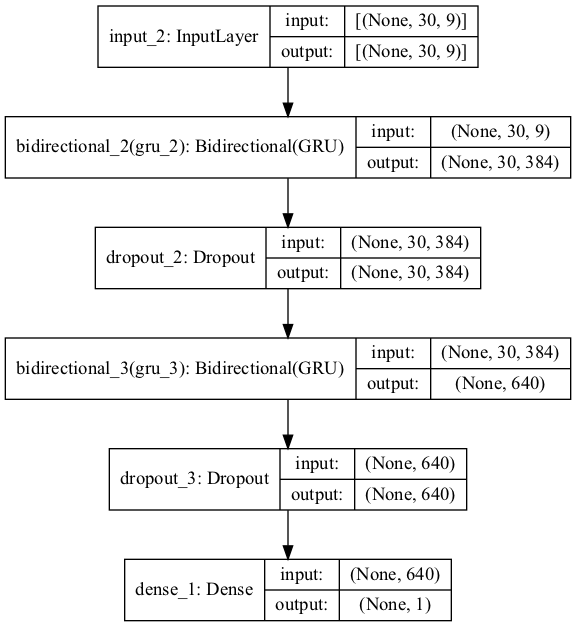

In [12]:
# plot model structure
create_dir_if_not_exist(MODEL_STRUCTURE_PATH)
plot_model(
    # make_bgru_model(input_dim=X_train_hk[fns_hk[0]].shape[1],
    #                 feature_cnt=X_train_hk[fns_hk[0]].shape[2]
    #                 ),
    make_bgru_model(input_dim=X_train_hk.shape[1],
                    feature_cnt=X_train_hk.shape[2]
                    ),
    show_shapes=True,
    show_layer_names=True,
    to_file="{}/BGRU_structure.png".format(MODEL_STRUCTURE_PATH)
)


### Model training
##### Train BGRU model for Hong Kong Stocks

In [13]:
create_dir_if_not_exist(HK_MODELS_CHECKPOINT_PATH)
create_dir_if_not_exist(US_MODELS_CHECKPOINT_PATH)

In [14]:
hk_bgru_cp = ModelCheckpoint(
    filepath=hk_bgru_file_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
    mode="min"
)

hk_bgru_es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10,
    verbose=1,
    # restore_best_weights=True, # added to prevent overfitting in iterative fit()
    min_delta=0.0001, # https://stackoverflow.com/a/63495687/9500852
)

# log history per epochs
hk_csv_log = CSVLogger(hk_bgru_training_progress_history_path)

hk_bgru_model = None
# check if we have previously trained model or not, ref: https://stackoverflow.com/a/56425146/9500852
if os.path.exists(hk_bgru_file_path):
    print("Found existing model")
    hk_bgru_model = load_model(hk_bgru_file_path)
    # score = hk_bgru_model.evaluate()
else:
    print("No existing model is found")
    # hk_bgru_model = make_bgru_model(
    #     input_dim=X_train_hk[fns_hk[0]].shape[1],
    #     feature_cnt=X_train_hk[fns_hk[0]].shape[2]
    # )
    hk_bgru_model = make_bgru_model(
        input_dim=X_train_hk.shape[1],
        feature_cnt=X_train_hk.shape[2]
    )

# start fitting the model
# hk_bgru_history = None
#
# for i in range(len(fns_hk)):
#     print("\n--- Training {}, {} stocks remains ---".format(fns_hk[i], len(fns_hk) - i))
#     tmp_hk_bgru_history = hk_bgru_model.fit(
#         x=X_train_hk[fns_hk[i]],
#         y=y_train_hk[fns_hk[i]],
#         validation_data=(X_test_hk[fns_hk[i]], y_test_hk[fns_hk[i]]),
#         epochs=TRAIN_EPOCHS,
#         callbacks=[
#             hk_bgru_cp,
#             hk_bgru_es
#         ]
#     )
#
#     # Append to previous histories
#     if hk_bgru_history is None:
#         hk_bgru_history = tmp_hk_bgru_history.history
#     else:
#         for dict_key in hk_bgru_history.keys():
#             hk_bgru_history.update({
#                 dict_key: hk_bgru_history[dict_key] + tmp_hk_bgru_history.history[dict_key]
#             })
#
#     # Save model per fit() iteration
#     hk_bgru_model.save(hk_bgru_file_path)
#     print("After trained {}, Model Saved".format(fns_hk[i]))
#
#     # Save history per fit() iteration
#     np.save(hk_bgru_train_history_file_path, hk_bgru_history)
#     print("After trained {}, History Saved, loss len: {}".format(fns_hk[i], len(hk_bgru_history["loss"])))
#
#     # SAVE HISTORY INDIVIUALLY PER fit() interation
#     # np.save(hk_bgru_train_history_file_path.format(HK_MODELS_CHECKPOINT_PATH, fns_hk[i]), hk_bgru_history.history)
#     # print("After trained {}, History Saved".format(fns_hk[i])))

hk_bgru_history = hk_bgru_model.fit(
    x=X_train_hk,
    y=y_train_hk,
    validation_data=(X_test_hk, y_test_hk),
    epochs=TRAIN_EPOCHS,
    callbacks=[
        hk_bgru_cp,
        hk_bgru_es,
        hk_csv_log
    ]
)

# save the model
if hk_bgru_model is not None:
    hk_bgru_model.save(hk_bgru_file_path)
    print("Model Saved")

# save the training history
if hk_bgru_history is not None:
    np.save(hk_bgru_train_history_file_path, hk_bgru_history.history)
    # np.save(hk_bgru_train_history_file_path, hk_bgru_history)
    print("History Saved")

No existing model is found
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 30, 384)           233856    
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 384)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 640)               1355520   
_________________________________________________________________
dropout_5 (Dropout)          (None, 640)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 641       
Total params: 1,590,017
Trainable params: 1,590,017
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2982/2982 [==============================] - 265s 88ms/step - loss

##### Train BGRU model for United States stocks

In [15]:
us_bgru_cp = ModelCheckpoint(
    filepath=us_bgru_file_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
    mode="min"
)

us_bgru_es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=10,
    # restore_best_weights=True, # added to prevent overfitting in iterative fit()
    min_delta=0.0001, # https://stackoverflow.com/a/63495687/9500852
)

# log history per epochs
us_csv_log = CSVLogger(us_bgru_training_progress_history)

us_bgru_model = None
# check if we have previously trained model or not, ref: https://stackoverflow.com/a/56425146/9500852
if os.path.exists(us_bgru_file_path):
    print("Found existing model")
    us_bgru_model = load_model(us_bgru_file_path)

else:
    print("No existing model is found")
    # us_bgru_model = make_bgru_model(
    #     input_dim=X_train_us[fns_us[0]].shape[1],
    #     feature_cnt=X_train_us[fns_us[0]].shape[2]
    # )
    us_bgru_model = make_bgru_model(
        input_dim=X_train_us.shape[1],
        feature_cnt=X_train_us.shape[2]
    )

# start fitting the model
# us_bgru_history = None
#
# for i in range(len(fns_us)):
#     print("\n--- Training {}, {} stocks remains ---".format(fns_us[i], len(fns_us) - i))
#     tmp_us_bgru_history = us_bgru_model.fit(
#         x=X_train_us[fns_us[i]],
#         y=y_train_us[fns_us[i]],
#         validation_data=(X_test_us[fns_us[i]], y_test_us[fns_us[i]]),
#         epochs=TRAIN_EPOCHS,
#         callbacks=[
#             us_bgru_cp,
#             us_bgru_es,
#         ]
#     )
#
#     # Append to previous histories
#     if us_bgru_history is None:
#         us_bgru_history = tmp_us_bgru_history.history
#     else:
#         for dict_key in us_bgru_history.keys():
#             # us_bgru_history[dict_key] = us_bgru_history[dict_key] + tmp_us_bgru_history.history[dict_key]
#             us_bgru_history.update({
#                 dict_key: us_bgru_history[dict_key] + tmp_us_bgru_history.history[dict_key]
#             })
#
#     # Save model per fit() iteration
#     us_bgru_model.save(us_bgru_file_path)
#     print("After trained {}, Model Saved".format(fns_us[i]))
#
#     np.save(us_bgru_train_history_file_path, us_bgru_history)
#     print("After trained {}, History Saved".format(fns_us[i]))

us_bgru_history = us_bgru_model.fit(
    x=X_train_us,
    y=y_train_us,
    validation_data=(X_test_us, y_test_us),
    epochs=TRAIN_EPOCHS,
    callbacks=[
        us_bgru_cp,
        us_bgru_es,
        us_csv_log
    ]
)

# save the model
if us_bgru_model is not None:
    us_bgru_model.save(us_bgru_file_path)
    print("Model Saved")

# save the training history
if us_bgru_history is not None:
    np.save(us_bgru_train_history_file_path, us_bgru_history.history)
    # np.save(us_bgru_train_history_file_path, us_bgru_history)
    print("History Saved")


No existing model is found
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 30, 384)           233856    
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 384)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 640)               1355520   
_________________________________________________________________
dropout_7 (Dropout)          (None, 640)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 641       
Total params: 1,590,017
Trainable params: 1,590,017
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
3046/3046 [==============================] - 269s 88ms/step - loss

3046/3046 [==============================] - 267s 88ms/step - loss: 0.0011 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0329 - mean_absolute_percentage_error: 36.7404 - val_loss: 0.0015 - val_mean_absolute_error: 0.0245 - val_root_mean_squared_error: 0.0385 - val_mean_absolute_percentage_error: 80.4887

Epoch 00019: val_loss improved from 0.00173 to 0.00148, saving model to ./model/us/bgru.h5
Epoch 20/100
3046/3046 [==============================] - 267s 88ms/step - loss: 9.4522e-04 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0307 - mean_absolute_percentage_error: 44.9932 - val_loss: 0.0013 - val_mean_absolute_error: 0.0222 - val_root_mean_squared_error: 0.0356 - val_mean_absolute_percentage_error: 71.5078

Epoch 00020: val_loss improved from 0.00148 to 0.00127, saving model to ./model/us/bgru.h5
Epoch 21/100
3046/3046 [==============================] - 266s 87ms/step - loss: 9.2034e-04 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0303 - mean_

### Other testing codes (to be removed)


In [21]:
# Test train for one stock only

# hk_bgru_cp = ModelCheckpoint(
#     filepath=hk_bgru_file_path,
#     monitor="val_loss",
#     save_best_only=True,
#     verbose=1,
#     mode="min"
# )
#
# hk_bgru_es = EarlyStopping(
#     monitor="val_loss",
#     mode="min",
#     patience=10
# )
#
# hk_bgru_model = None
# # check if we have previously trained model or not, ref: https://stackoverflow.com/a/56425146/9500852
# if os.path.exists(hk_bgru_file_path):
#     print("Found existing model")
#     hk_bgru_model = load_model(hk_bgru_file_path)
#     # score = hk_bgru_model.evaluate()
# else:
#     print("No existing model is found")
#     hk_bgru_model = make_bgru_model(
#         input_dim=X_train_hk[fns_hk[0]].shape[1],
#         feature_cnt=X_train_hk[fns_hk[0]].shape[2]
#     )
#
# # from tensorflow.keras.layers import LSTM
# # hk_bgru_model = Sequential()
# # hk_bgru_model.add(Bidirectional(LSTM(units= 128), input_shape=(X_train_hk[fns_hk[0]].shape[1], X_train_hk[fns_hk[0]].shape[2])))
# # hk_bgru_model.add(Dense(64))
# # hk_bgru_model.add(Dense(units=1))
# #
# # hk_bgru_model.compile(optimizer=Adam(lr = 0.001), loss='mean_squared_error',
# #                   metrics=[
# #                     # MeanAbsoluteError(),
# #                     # RootMeanSquaredError(),
# #                     # MeanAbsolutePercentageError()
# #                 ])
#
# # print(hk_bgru_model.summary())
#
# print("\n--- Training {}, {} stocks remains ---".format("1038.HK", 0))
# hk_bgru_history = hk_bgru_model.fit(
#     x=X_train_hk["1038.HK"],
#     y=y_train_hk["1038.HK"],
#     validation_data=(X_test_hk["1038.HK"], y_test_hk["1038.HK"]),
#     epochs=TRAIN_EPOCHS,
#     # epochs=15,
#     # batch_size=150,
#     callbacks=[
#         hk_bgru_cp,
#         hk_bgru_es
#     ],
#     shuffle=False
# )
#
# hk_bgru_model.save(hk_bgru_file_path)
# print("After trained {}, Model Saved".format("1038.HK"))
# np.save(hk_bgru_train_history_file_path, hk_bgru_history.history)
# print("History Saved")

In [22]:
# X_train_hk[fns_hk[0]].shape

In [23]:
hk_gru_history_dict = np.load(hk_bgru_train_history_file_path, allow_pickle=True).item()

dict_key = "loss"
print(len(hk_gru_history_dict["loss"]))

# hk_bgru_history_dict["loss"] = hk_gru_history_dict["loss"] + hk_gru_history_dict["loss"]
hk_bgru_history_dict.update({
    dict_key: hk_gru_history_dict["loss"] + hk_gru_history_dict["loss"]
})

# print("updated")

print(len(hk_bgru_history_dict["loss"]))

print(hk_bgru_history_dict)



14
28
{'loss': [0.0034380070865154266, 0.001773253083229065, 0.0018697429914027452, 0.0018408974865451455, 0.0017538601532578468, 0.0019218591041862965, 0.0018185654189437628, 0.0018715831683948636, 0.0017770979320630431, 0.0017107586609199643, 0.001495918957516551, 0.0013813546393066645, 0.0013567311689257622, 0.0013790815137326717, 0.0034380070865154266, 0.001773253083229065, 0.0018697429914027452, 0.0018408974865451455, 0.0017538601532578468, 0.0019218591041862965, 0.0018185654189437628, 0.0018715831683948636, 0.0017770979320630431, 0.0017107586609199643, 0.001495918957516551, 0.0013813546393066645, 0.0013567311689257622, 0.0013790815137326717], 'mean_absolute_error': [0.039962511509656906, 0.03146572411060333, 0.032192450016736984, 0.03176037594676018, 0.030967343598604202, 0.03256459906697273, 0.03153816610574722, 0.032090310007333755, 0.031070921570062637, 0.03030375763773918, 0.028219422325491905, 0.02704673260450363, 0.026716720312833786, 0.02702338621020317], 'root_mean_square